# Fraud Detection Work

## Introduction and Motivation

The following code is intended for the final year project 'Machine Learning for Credit Card Fraud Detection' by Michael Brozhko.

### Combine CSVs of Dataset

Initially, the dataset uses was already pre split into training and testing data. However, for this experiment to be conducted with high validity, I recombined the dataset and randomly split later to ensure result reliability.

In [ ]:
import os

# The following code is intended to combine the two csv files associated with the dataset in use. 
# The dataset should be randomly split into testing and training data, as it is unclear how it was initially split

os.chdir("/Users/michael/Documents/Aston/FYP/Dataset")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

### Import Libraries

In [285]:
#import relevant libaries

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import datetime as dt
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

from sklearn.svm import SVC
from IPython import display
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Load Dataset

Load the dataset into a pandas dataframe and output the data types

In [286]:
# load dataset into a new dataframe and show head
df = pd.read_csv("combined_csv.csv")
# List the initial datatypes of columns in dataframe
print(df.dtypes)
df.head()

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


## Data Preprocessing

In the data preprocessing stage we deal with:
    -Type conversions
    -Removal of unnecessary data
    -Reformatting of data to more model-friendly format

### Check For Null Values

In [287]:
print(df.isnull().sum())

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


### Datetime Column Seperation

This segment deals with seperating the datetime column into seperate columns - year, hour, day, month. 
There may be a correlation between different times of day, different days and different months with fraudulent activity.

In [339]:
#The following functionality aims to seperate the datetime column
#so that it can be processed as multiple features
#   -This can offer greater performance
#   -Allow the identification of trends with regards to specific days, time of day, etc

#drop unnecessary columns
dfn = df.drop(['Unnamed: 0','cc_num','trans_date_trans_time','first','street','last','trans_num','dob','merchant', 'unix_time'],axis=1)
dfn.dropna()

#define several empty lists for following functionality
dfn['age']=dt.date.today().year-pd.to_datetime(df['dob']).dt.year
dfn['hour']=pd.to_datetime(df['trans_date_trans_time']).dt.hour
dfn['day']=pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
dfn['month']=pd.to_datetime(df['trans_date_trans_time']).dt.month

dfn.dtypes

category       object
amt           float64
gender         object
city           object
state          object
zip             int64
lat           float64
long          float64
city_pop        int64
job            object
merch_lat     float64
merch_long    float64
is_fraud        int64
age             int64
hour            int64
day             int64
month           int64
dtype: object

### Create New Features

Creating new features based on certain columns

In [340]:
# Add a feature that counts the number of transactions made by each credit card
dfn['num_transactions'] = df.groupby('cc_num')['trans_num'].transform('count')

# Add a feature that calculates the average transaction amount for each credit card
dfn['avg_transaction_amt'] = df.groupby('cc_num')['amt'].transform('mean')

# Add a feature that calculates the standard deviation of the transaction amounts for each credit card
dfn['transaction_amt_std'] = df.groupby('cc_num')['amt'].transform('std')

# Add a feature that calculates the distance between the merchant and the customer for each transaction
dfn['merchant_customer_distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)

# Add a feature that calculates the total amount spent by each credit card
dfn['total_spent'] = df.groupby('cc_num')['amt'].transform('sum')

dfn.dtypes

category                       object
amt                           float64
gender                         object
city                           object
state                          object
zip                             int64
lat                           float64
long                          float64
city_pop                        int64
job                            object
merch_lat                     float64
merch_long                    float64
is_fraud                        int64
age                             int64
hour                            int64
day                             int64
month                           int64
num_transactions                int64
avg_transaction_amt           float64
transaction_amt_std           float64
merchant_customer_distance    float64
total_spent                   float64
dtype: object

In [341]:
print(dfn['state'].nunique())
print(dfn['city'].nunique())
print(dfn['job'].nunique())

51
906
497


In [342]:
dfn.head()

,category,amt,gender,city,state,zip,lat,long,city_pop,job,...,is_fraud,age,hour,day,month,num_transactions,avg_transaction_amt,transaction_amt_std,merchant_customer_distance,total_spent
0,misc_net,4.97,F,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",...,0,35,0,1,1,8781,89.408743,127.515575,0.872830,785098.17
1,grocery_pos,107.23,F,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,...,0,45,0,1,1,13086,56.078113,159.189685,0.272310,733838.19
2,entertainment,220.11,M,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,...,0,61,0,1,1,2205,69.924272,116.635646,0.975845,154183.02
3,gas_transport,45.00,M,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,...,0,56,0,1,1,2229,80.090040,279.952143,0.919802,178520.70
4,misc_pos,41.96,M,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,...,0,37,0,1,1,8766,95.341146,94.312080,0.868505,835760.49


### Feature Encoding

Encoding categorical features

In [343]:
from sklearn.preprocessing import OneHotEncoder

#The following column deals with data preprocessing involving:
#   -Type conversions
#   -Removal of unnecessary data
#   -Reformatting of data to more model-friendly format

# Create a OneHotEncoder object
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(dfn[['gender', 'category','state']]).toarray()
new_columns = list(encoder.get_feature_names_out(['gender', 'category','state']))
dfn[new_columns] = encoded_data
dfn = dfn.drop(['gender', 'category','state','job','city'], axis=1)


# #Perform Target Encoding on features 'city', 'job', 'state'
# tenc= ce.TargetEncoder()

# df_city=tenc.fit_transform(dfn['city'],dfn['is_fraud'])
# dfn = df_city.join(dfn.drop('city',axis = 1))

# # df_job=tenc.fit_transform(dfn['job'],dfn['is_fraud'])
# # dfn = df_job.join(dfn.drop('job',axis = 1))

# df_state=tenc.fit_transform(dfn['state'],dfn['is_fraud'])
# dfn = df_state.join(dfn.drop('state',axis = 1))

# Convert the 'is_fraud' column to boolean data type
# dfn['is_fraud'] = dfn['is_fraud'].astype(bool)

dfn.dtypes

amt                           float64
zip                             int64
lat                           float64
long                          float64
city_pop                        int64
merch_lat                     float64
merch_long                    float64
is_fraud                        int64
age                             int64
hour                            int64
day                             int64
month                           int64
num_transactions                int64
avg_transaction_amt           float64
transaction_amt_std           float64
merchant_customer_distance    float64
total_spent                   float64
gender_F                      float64
gender_M                      float64
category_entertainment        float64
category_food_dining          float64
category_gas_transport        float64
category_grocery_net          float64
category_grocery_pos          float64
category_health_fitness       float64
category_home                 float64
category_kid

In [344]:
dfn.head()

,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,hour,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,4.97,28654,36.0788,-81.1781,3495,36.011293,-82.048315,0,35,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,107.23,99160,48.8878,-118.2105,149,49.159047,-118.186462,0,45,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,220.11,83252,42.1808,-112.2620,4154,43.150704,-112.154481,0,61,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,45.00,59632,46.2306,-112.1138,1939,47.034331,-112.561071,0,56,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41.96,24433,38.4207,-79.4629,99,38.674999,-78.632459,0,37,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Outlier Detection and Removal

In [345]:
# Calculate the correlation coefficient between 'amount' and 'is_fraud'
corr = dfn['amt'].corr(dfn['is_fraud'])

# Print the correlation coefficient
print("Correlation Coefficient:", corr)

Correlation Coefficient: 0.2093078472298056


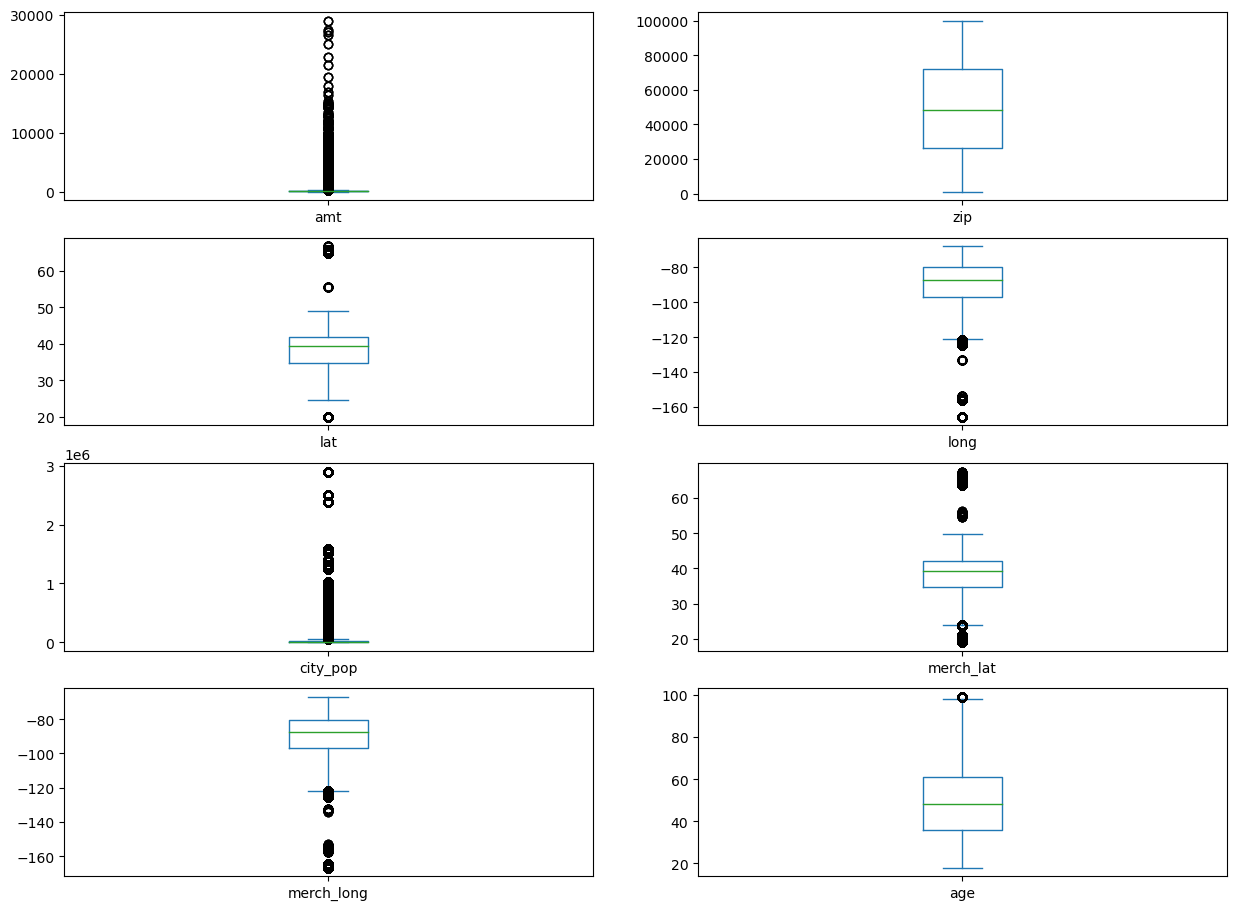

In [346]:
data = dfn[['amt','zip','lat','long','city_pop','merch_lat','merch_long','age']]
data.plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20));

In [347]:
def get_min_max_no_outliers(df, col1, col2):
    # Calculate the interquartile range (IQR) for each column
    Q1 = df[[col1, col2]].quantile(0.25)
    Q3 = df[[col1, col2]].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    outlier_threshold = 1.5

    # Define non-outlier range for each column
    min_val = Q1 - outlier_threshold * IQR
    max_val = Q3 + outlier_threshold * IQR

    # Filter the DataFrame to exclude outliers
    df_filtered = df[(df[col1] >= min_val[col1]) & (df[col1] <= max_val[col1]) &
                     (df[col2] >= min_val[col2]) & (df[col2] <= max_val[col2])]

    print("Minimum Values:\n",df_filtered[[col1, col2]].min())
    print("Maximum Values:\n",df_filtered[[col1, col2]].max())

get_min_max_no_outliers(dfn, 'age', 'amt')

Minimum Values:
 age    18.0
amt     1.0
dtype: float64
Maximum Values:
 age     98.00
amt    193.29
dtype: float64


In [348]:
print(len(dfn))
dfn = dfn[dfn['age']<=98]
print(len(dfn))

5557182
5554977


Fraudulent:  28953
Non-fraudulent:  5528229


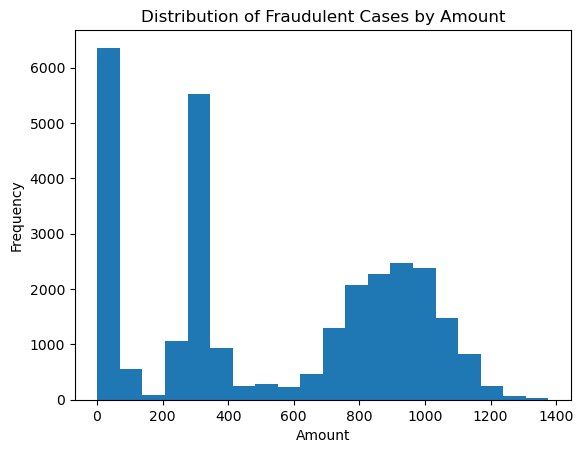

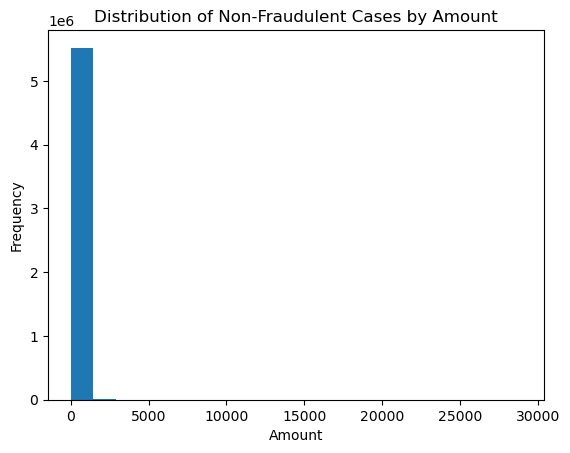

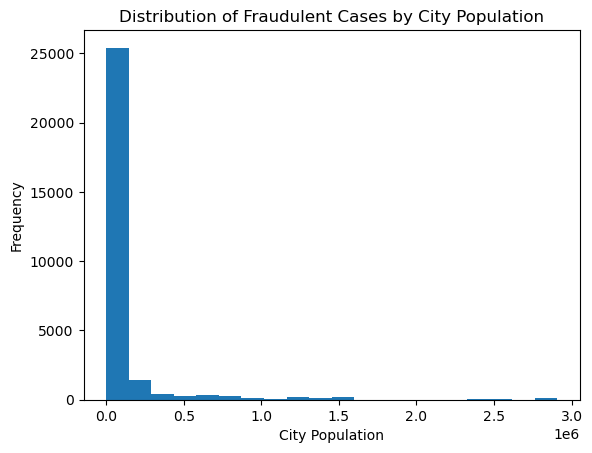

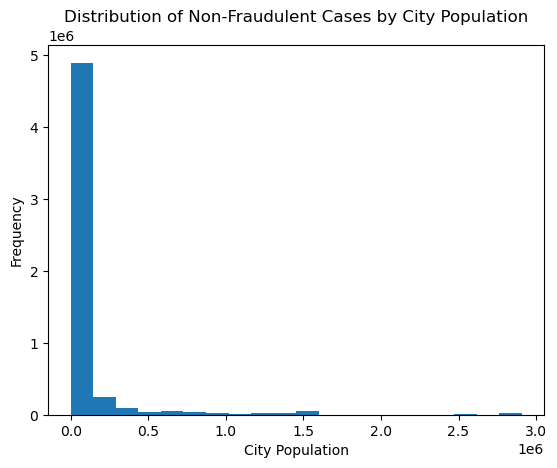

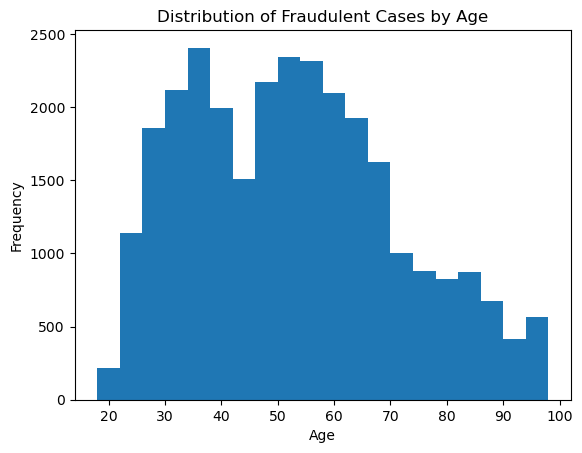

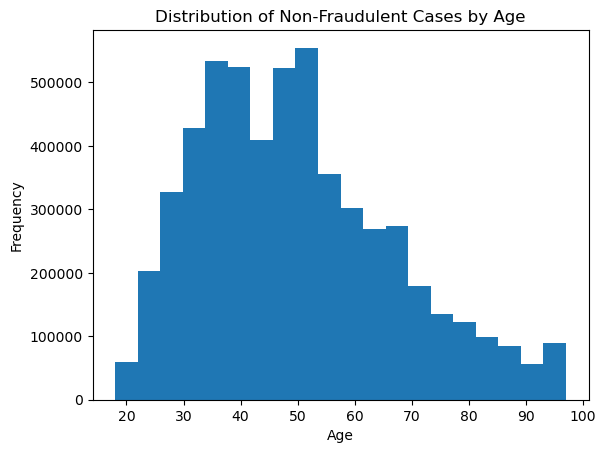

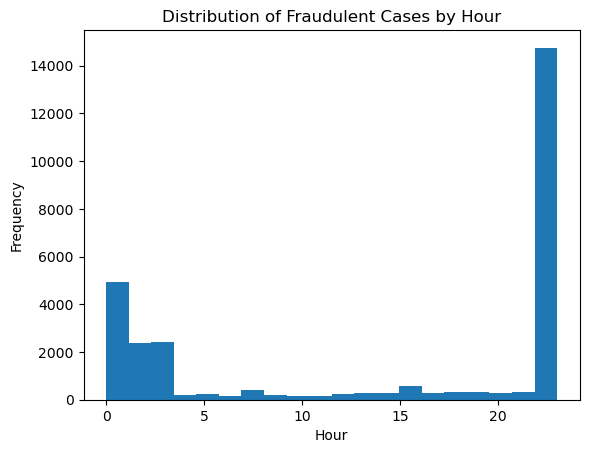

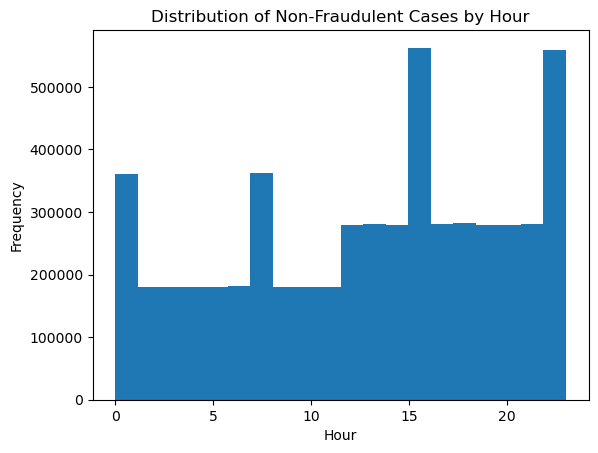

In [349]:
fraud_df = dfn[dfn['is_fraud'] == 1]
nonFraud_df = dfn[dfn['is_fraud'] == 0]

print("Fraudulent: ",len(f))
print("Non-fraudulent: ",len(nf))

def plotGraphs(bins):
    
    plt.hist(fraud_df['amt'], bins=bins)
    plt.xlabel('Amount')
    plt.ylabel('Frequency')
    plt.title('Distribution of Fraudulent Cases by Amount')
    plt.show()
    
    plt.hist(nonFraud_df['amt'], bins=bins)
    plt.xlabel('Amount')
    plt.ylabel('Frequency')
    plt.title('Distribution of Non-Fraudulent Cases by Amount')
    plt.show()
    
    plt.hist(fraud_df['city_pop'], bins=bins)
    plt.xlabel('City Population')
    plt.ylabel('Frequency')
    plt.title('Distribution of Fraudulent Cases by City Population')
    plt.show()
    
    plt.hist(nonFraud_df['city_pop'], bins=bins)
    plt.xlabel('City Population')
    plt.ylabel('Frequency')
    plt.title('Distribution of Non-Fraudulent Cases by City Population')
    plt.show()
    
    plt.hist(fraud_df['age'], bins=bins)
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Distribution of Fraudulent Cases by Age')
    plt.show()
    
    plt.hist(nonFraud_df['age'], bins=bins)
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Distribution of Non-Fraudulent Cases by Age')
    plt.show()
    
    plt.hist(fraud_df['hour'], bins=bins)
    plt.xlabel('Hour')
    plt.ylabel('Frequency')
    plt.title('Distribution of Fraudulent Cases by Hour')
    plt.show()
    
    plt.hist(nonFraud_df['hour'], bins=bins)
    plt.xlabel('Hour')
    plt.ylabel('Frequency')
    plt.title('Distribution of Non-Fraudulent Cases by Hour')
    plt.show()
    
plotGraphs(20)

### Features and Label Seperation

In [350]:
# #labels (y) are the what we are trying to predict and as such, is the 'is_fraud' column
# y=dfn_more['is_fraud'].values
# #format data and for features (X) remove 'is_fraud' column since this is what we are trying to predict
# X=dfn_more.drop(['is_fraud'], axis='columns')


#labels (y) are the what we are trying to predict and as such, is the 'is_fraud' column
y=dfn['is_fraud'].values
#format data and for features (X) remove 'is_fraud' column since this is what we are trying to predict
X=dfn.drop(['is_fraud'], axis='columns')

### Scaling Data

A standard scaler is used to standerdise the data with the normal distribution with mean = 0

In [351]:
from sklearn.preprocessing import StandardScaler
#scale the data 

def scaling(X):
    sc = StandardScaler()
    X['amt'] = sc.fit_transform(X[['amt']])
    X['zip'] = sc.fit_transform(X[['zip']])
    X['lat'] = sc.fit_transform(X[['lat']])
    X['long'] = sc.fit_transform(X[['long']])
    X['city_pop'] = sc.fit_transform(X[['city_pop']])
    X['merch_lat'] = sc.fit_transform(X[['merch_lat']])
    X['merch_long'] = sc.fit_transform(X[['merch_long']])
    X['hour'] = sc.fit_transform(X[['hour']])
    X['day'] = sc.fit_transform(X[['day']])
    X['month'] = sc.fit_transform(X[['month']])
    X['age'] = sc.fit_transform(X[['age']])
    X['merchant_customer_distance'] = sc.fit_transform(X[['merchant_customer_distance']])
    X['num_transactions'] = sc.fit_transform(X[['num_transactions']])
    X['avg_transaction_amt'] = sc.fit_transform(X[['avg_transaction_amt']])
    X['transaction_amt_std'] = sc.fit_transform(X[['transaction_amt_std']])
    X['total_spent'] = sc.fit_transform(X[['total_spent']])
    return X

In [352]:
pd.options.display.max_rows = 4000
pd.set_option('display.max_colwidth', None)

### Principle Component Analysis

In [353]:
def pca_analysis(X):
    cs = X.columns
    X = scaling(X)
    
    pca = PCA()
    X_pca = pca.fit_transform(X)
    values = (pca.explained_variance_ratio_*100)
    
    result = pd.DataFrame(data=[values],columns=cs)
    
    # Select the column indices that start with 'state...'
    states = [i for i, name in enumerate(cs) if name.startswith('state')]

    # Sum the explained variance ratio for the selected columns
    st = str(pca.explained_variance_ratio_[states].sum()) + "for states"
    
    # Select the column indices that start with 'state...'
    categories = [i for i, name in enumerate(cs) if name.startswith('category')]

    # Sum the explained variance ratio for the selected columns
    cat = str(pca.explained_variance_ratio_[categories].sum()) + "for categories"
    
    print(st)
    
    print(cat)
    
    # The scope of these changes made to
    # pandas settings are local to with statement.
    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.precision', 3,
                           ):
        print(result)
    
#     fig, ax = plt.subplots(figsize=(20, 15))
#     fig.patch.set_visible(False)

#     ax = sns.barplot(x=values, y=cs, hue=cs, orient='h', dodge=False, ax=ax, palette='turbo')
#     for bars_group in ax.containers:
#         ax.bar_label(bars_group, padding=3, fontsize=18)
#     ax.legend(bbox_to_anchor=(1, .5), loc='center left',fontsize=15)
#     plt.xlabel('Explained Variance Ratio %', fontsize=25);
#     ax.margins(x=0.15)
#     sns.despine()
#     plt.tight_layout()
#     plt.show()
    
pca_analysis(X)

0.03667080570591616for states
0.04257635780650986for categories
      amt     zip     lat   long  city_pop  merch_lat  merch_long    age  \
0  15.958  12.174  10.957  6.339     5.785      5.467       5.439  5.412   

    hour    day  month  num_transactions  avg_transaction_amt  \
0  5.351  5.125  4.876             4.061                2.431   

   transaction_amt_std  merchant_customer_distance  total_spent  gender_F  \
0                0.735                       0.531        0.503     0.487   

   gender_M  category_entertainment  category_food_dining  \
0     0.444                   0.417                 0.393   

   category_gas_transport  category_grocery_net  category_grocery_pos  \
0                   0.384                  0.37                 0.363   

   category_health_fitness  category_home  category_kids_pets  \
0                    0.341          0.334               0.315   

   category_misc_net  category_misc_pos  category_personal_care  \
0              0.307         

## Feature Selection

Based on PCA results certain features are selected while others are discarded

In [354]:
# Filter out the columns that start with 'state'

# X = X[['amt','zip','lat','long','city_pop','merch_lat','merch_long','age','hour','day','month','num_transactions','avg_transaction_amt']]
# X = X[['amt','zip','lat','long','city_pop','merch_lat','merch_long','age','hour','day','month','num_transactions','avg_transaction_amt','category_gas_transport','category_grocery_net', 'category_grocery_pos','category_health_fitness', 'category_home', 'category_kids_pets','category_misc_net', 'category_misc_pos', 'category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel']]

X = X[['amt','zip','lat','long','city_pop','merch_lat','merch_long','age','hour','day','month','num_transactions','avg_transaction_amt']]

In [355]:
# y = df['is_fraud']
# y.to_csv( "y.csv", index=False, encoding='utf-8-sig')

## Key Functions

### plotResults()
The following function is defined to plot results based on a parameter 'report' which is a passed classification report

In [356]:
def plotResults(report,model):
    df = pd.DataFrame(report)
    df.iloc[:3, :2].T.plot(kind='bar')
    plt.title(model)
    plt.xlabel('Class')
    plt.ylabel('Performance')
    plt.show()

### GridSearchCV

Search for best hyperparameters of a model

In [357]:
def gridSearch(model, param_grid):
    grid = GridSearchCV(model, param_grid, refit = True, verbose = 3)
    return grid

### PlotLearning()

Plot the learning curve for specific model train and test scores

In [358]:
from sklearn.model_selection import learning_curve

def plotLearning(model, X, y):
    
    # Define the training set sizes to use for the learning curve
    train_sizes = np.linspace(0.1, 1.0, 10)

    # Calculate the learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, train_sizes=train_sizes, scoring='accuracy')

    # Calculate the mean and standard deviation of the training and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')

    # Add error bars showing the standard deviation of the scores
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    # Add labels and legend to the plot
    plt.xlabel('Training set size')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

### RunModels()

Main function called to run the desired Machine Learning models on specified parameters for features (X) and labels (y)

This function makes calls to the various prior defined functions.

Certain models are commented out/in for testing purposes. For reviewing models, comment/uncomment different code blocks.

In [361]:
# from tensorflow.keras.optimizers.legacy import Adam
# from keras.models import Sequential
# from keras.layers import Activation, Dense
# from keras.optimizers import SGD
# from tensorflow.keras import layers

# Function to run models

# Avoids code repitiion by encapsulating all functionality in the function, allowing models on different data splits 
# and sample sizes to be run by calling function and passing relevamt parameters


# The function takes the features (x), labels (y) and text (t) as parameters
# Performs:
#     1. Train-testing data split
#     2. Model training and testing
#     3. Output of performance metrics through classification_report

# The function does not return anything

def runModels(X, y, t):
    print("Performance metrics for "+t+" data")
    print(Counter(y))
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.33,random_state=42,stratify=y)
    
    regr = LogisticRegression(penalty='l2',max_iter=1000, class_weight='balanced',fit_intercept=True,solver='lbfgs')

#     regr = gridSearch(LogisticRegression(max_iter=1000, class_weight='balanced',fit_intercept=True), {
#         'solver'  : ['lbfgs', 'newton-cg', 'liblinear'],
#         'C'       : [0.01,0.05,0.1,1],
#     })
    
    plotLearning(regr, X, y)
    
    regr.fit(X_train, Y_train)
    
    Y_trainL = regr.predict(X_train)
    print("LR Train Accuracy\n",accuracy_score(Y_train, Y_trainL))
    print("LR Train Scores\n",classification_report(Y_train, Y_trainL))
    
    Y_testL = regr.predict(X_test)
    print("LR Test Accuracy\n",accuracy_score(Y_test, Y_testL))
    print("LR Test Scores\n",classification_report(Y_test, Y_testL))
    
#     plotResults(classification_report(Y_test, Y_predL, digits=4,  output_dict=True), 'Logistic Regression')
    
#     print("Logistic Regression Grid Search")
#     print("Tuned Hyperparameters :", regr.best_params_)
#     print("Accuracy :",regr.best_score_)
    
    nb = GaussianNB()
        
#     nb = gridSearch(GaussianNB(), {
#         'var_smoothing' : [1e-12,1e-9, 1e-5, 0.00012, 0.0001, 0.00008]
#     })
    
    plotLearning(nb, X, y)
    
    nb.fit(X_train, Y_train)
    
    Y_trainG = nb.predict(X_train)
    print("NB Train Accuracy\n",accuracy_score(Y_train, Y_trainG))
    print("NB Train Scores\n",classification_report(Y_train, Y_trainG))
    
    Y_testG = nb.predict(X_test)
    print("NB Test Accuracy\n",accuracy_score(Y_test, Y_testG))
    print("NB Test Scores\n",classification_report(Y_test, Y_testG))
    
#     plotResults(classification_report(Y_test, Y_predG, digits=4,  output_dict=True), 'Guassian Naive Bayes')
    
#     print("Guassian NB Grid Search")
#     print("Tuned Hyperparameters :", nb.best_params_)
#     print("Accuracy :",nb.best_score_)

    KNN = KNeighborsClassifier(n_neighbors=3)

#     KNN = gridSearch(KNeighborsClassifier(n_neighbors=3), {
#         'weights' : ['uniform','distance']
#     })

#     plotLearning(KNN, X, y)
    
    KNN.fit(X_train, Y_train)
    
    Y_trainK = KNN.predict(X_train)
    print("KNN Train Accuracy\n",accuracy_score(Y_train, Y_trainK))
    print("KNN Train Scores\n",classification_report(Y_train, Y_trainK))
    
    Y_testK = KNN.predict(X_test)
    print("KNN Test Accuracy\n",accuracy_score(Y_test, Y_testK))
    print("KNN Test Scores\n",classification_report(Y_test, Y_testK))
    
#     Y_predK = KNN.predict(X_test)
#     print(classification_report(Y_test, Y_predK))
    
#     plotResults(classification_report(Y_test, Y_predK, digits=4,  output_dict=True),'K-Neighbours Classifier')
    
#     print("KNN Grid Search")
#     print("Tuned Hyperparameters :", nb.best_params_)
#     print("Accuracy :",nb.best_score_)

    xg = xgb.XGBClassifier(objective='binary:logistic',n_jobs=-1)
          
#     plotLearning(xg, X, y)
    
    xg.fit(X_train, Y_train)
    
    Y_trainXG = xg.predict(X_train)
    print("XGB Train Accuracy\n",accuracy_score(Y_train, Y_trainXG))
    print("XGB Train Scores\n",classification_report(Y_train, Y_trainXG))
    
    Y_testXG = xg.predict(X_test)
    print("XGB Test Accuracy\n",accuracy_score(Y_test, Y_testXG))
    print("XGB Test Scores\n",classification_report(Y_test, Y_testXG))
          
#     Y_predX = xg.fit(X_train, Y_train).predict(X_test)
#     print(classification_report(Y_test, Y_predX))
#     plotResults(classification_report(Y_test, Y_predX, digits=4,  output_dict=True), 'XGBClassifier')
    
    RF = RandomForestClassifier(n_estimators = 150)
          
    plotLearning(RF, X, y)
    
    RF.fit(X_train, Y_train)
    
    Y_trainRF = xg.predict(X_train)
    print("RF Train Accuracy\n",accuracy_score(Y_train, Y_trainRF))
    print("RF Train Scores\n",classification_report(Y_train, Y_trainRF))
    
    Y_testRF = xg.predict(X_test)
    print("RF Test Accuracy\n",accuracy_score(Y_test, Y_testRF))
    print("RF Test Scores\n",classification_report(Y_test, Y_testRF))
    
#     print(classification_report(Y_test, Y_predRF))
#     plotResults(classification_report(Y_test, Y_predRF, digits=4,  output_dict=True), 'Random Forest')
    
    mlp = MLPClassifier(hidden_layer_sizes=(200,150),max_iter=1200)
                
    plotLearning(mlp, X, y)
    
    mlp.fit(X_train, Y_train)
    
    Y_trainMLP = mlp.predict(X_train)
    print("MLP Train Accuracy\n",accuracy_score(Y_train, Y_trainMLP))
    print("MLP Train Scores\n",classification_report(Y_train, Y_trainMLP))
    
    Y_testMLP = mlp.predict(X_test)
    print("MLP Test Accuracy\n",accuracy_score(Y_test, Y_testMLP))
    print("MLP Test Scores\n",classification_report(Y_test, Y_testMLP))
          
#     print(classification_report(Y_test, Y_predMLP))        
#     plotResults(classification_report(Y_test, Y_predMLP, digits=4,  output_dict=True),'Multi Layer Perceptron')

#     X_train = X_train.values.reshape(6466, 4, 13)
#     Y_train = Y_train.reshape(6466, 4)
#     X_test = X_test.values.reshape(3185, 4, 13)
#     Y_test = Y_test.reshape(3185, 4)
    
#     model = tf.keras.Sequential()
#     model.add(keras.Input(shape=(4, 13)))
#     model.add(layers.GRU(12,activation='relu'))
#     model.add(layers.Dense(8,activation='relu'))
#     model.add(layers.Dense(4,activation='relu'))
#     model.add(layers.Dense(1, activation='sigmoid'))
    
#     model.compile(optimizer='adam',
#               loss="mse",
#               metrics=['accuracy'])
    
#     model.fit(X_train, Y_train, epochs=2)
    
#     print("Performance compared with test data")
#     Y_predM = model.predict(X_test)

#     loss, accuracy = model.evaluate(X_test, Y_test)
#     print(f'Test loss: {loss}, Test accuracy: {accuracy}')
    
#     print(loss)
#     print(accuracy)
#     print("Predicted Fraud: "+str(np.sum(Y_predM == 1)))
#     print("Truly Fraud: "+str(np.sum(Y_test == 1)))
    
#     print("Predicted not Fraud: "+str(np.sum(Y_predM == 0)))
#     print("Truly not Fraud: "+str(np.sum(Y_test == 0)))
#     Y_predM = np.array(Y_predM.reshape(12740,1))
    
#     print(classification_report(Y_test, Y_predM))
    
#     print('done')

## Results

Results analysis using the above functions is conducted on the data obtained from a variety of different sampling models as-well as the unsampled dataset

### Unsampled Data

Calculate prediction and analysis of results based on the unsampled data

Performance metrics for Unsampled data data
Counter({0: 5526045, 1: 28932})


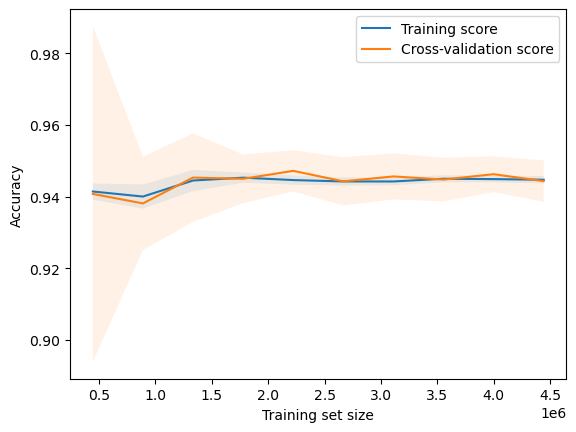

LR Train Accuracy
 0.9442672617854531
LR Train Scores
               precision    recall  f1-score   support

           0       1.00      0.95      0.97   3702450
           1       0.07      0.76      0.12     19384

    accuracy                           0.94   3721834
   macro avg       0.53      0.85      0.55   3721834
weighted avg       0.99      0.94      0.97   3721834

LR Test Accuracy
 0.9441543840278691
LR Test Scores
               precision    recall  f1-score   support

           0       1.00      0.95      0.97   1823595
           1       0.07      0.77      0.13      9548

    accuracy                           0.94   1833143
   macro avg       0.53      0.86      0.55   1833143
weighted avg       0.99      0.94      0.97   1833143



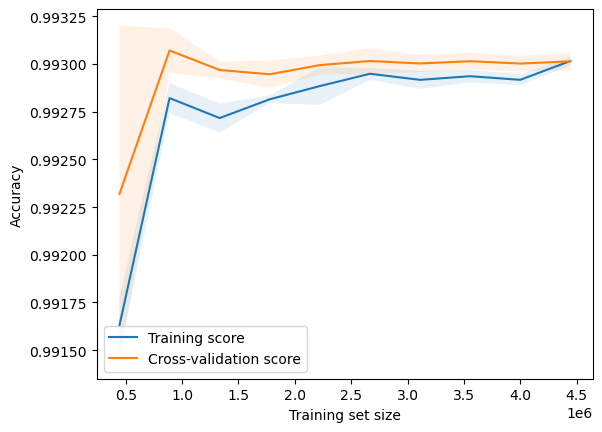

NB Train Accuracy
 0.9928830786112438
NB Train Scores
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   3702450
           1       0.37      0.50      0.42     19384

    accuracy                           0.99   3721834
   macro avg       0.68      0.75      0.71   3721834
weighted avg       0.99      0.99      0.99   3721834

NB Test Accuracy
 0.9929389032934146
NB Test Scores
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1823595
           1       0.37      0.51      0.43      9548

    accuracy                           0.99   1833143
   macro avg       0.68      0.75      0.71   1833143
weighted avg       0.99      0.99      0.99   1833143

KNN Train Accuracy
 0.9996740854105798
KNN Train Scores
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   3702450
           1       0.97      0.97      0.97     19384

    accuracy     


KeyboardInterrupt



In [362]:
#Run Models
runModels(X, y, "Unsampled data")

### Random Oversampling

Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset.

For this experiment, we will oversample the data in ratios 1:1, 10:1 and 100:1 
Since the undersampled data was at ratio 368546:19302 majority class to minority class, random oversampling will scale up the number of datapoints for the minority class to match the above ratios.

Performance metrics for Random Oversampling 1:1 data
Counter({0: 5528229, 1: 5528229})
(7407826, 13)
(7407826,)
(3648632, 13)
(3648632,)
              precision    recall  f1-score   support

           0       0.80      0.95      0.87   1824316
           1       0.93      0.76      0.84   1824316

    accuracy                           0.85   3648632
   macro avg       0.87      0.85      0.85   3648632
weighted avg       0.87      0.85      0.85   3648632



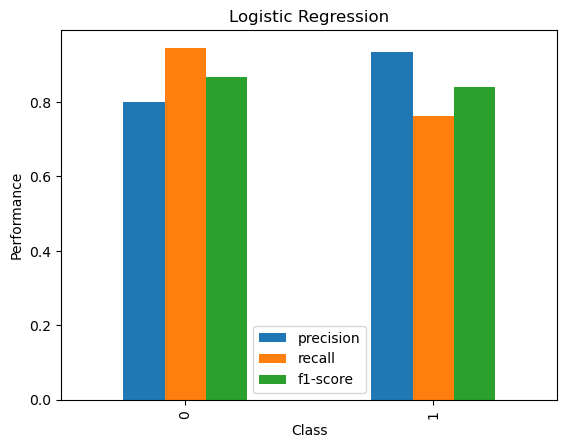

              precision    recall  f1-score   support

           0       0.69      0.99      0.81   1824316
           1       0.98      0.55      0.71   1824316

    accuracy                           0.77   3648632
   macro avg       0.83      0.77      0.76   3648632
weighted avg       0.83      0.77      0.76   3648632



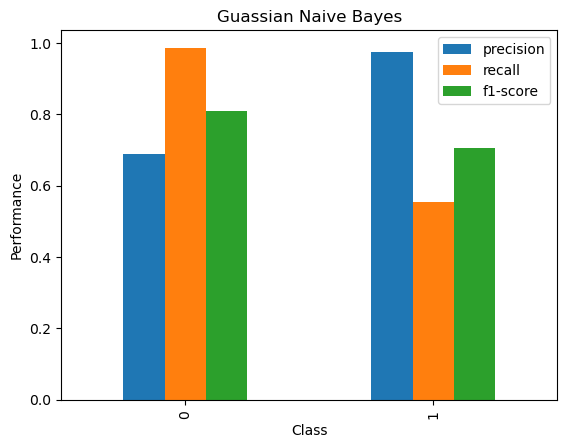

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1824316
           1       1.00      1.00      1.00   1824316

    accuracy                           1.00   3648632
   macro avg       1.00      1.00      1.00   3648632
weighted avg       1.00      1.00      1.00   3648632



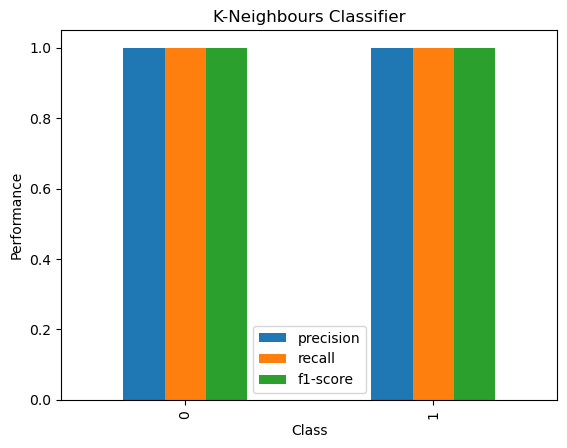

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1824316
           1       0.98      1.00      0.99   1824316

    accuracy                           0.99   3648632
   macro avg       0.99      0.99      0.99   3648632
weighted avg       0.99      0.99      0.99   3648632



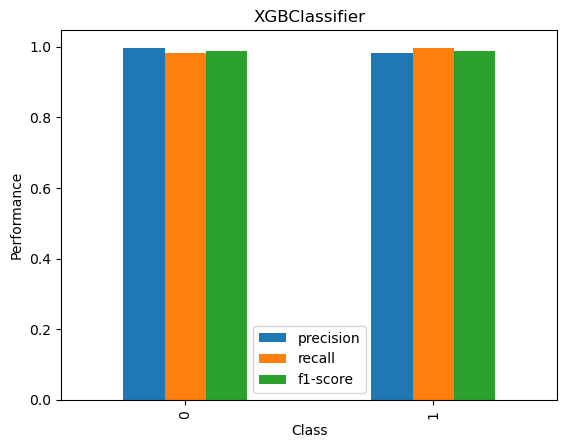

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1824316
           1       1.00      1.00      1.00   1824316

    accuracy                           1.00   3648632
   macro avg       1.00      1.00      1.00   3648632
weighted avg       1.00      1.00      1.00   3648632



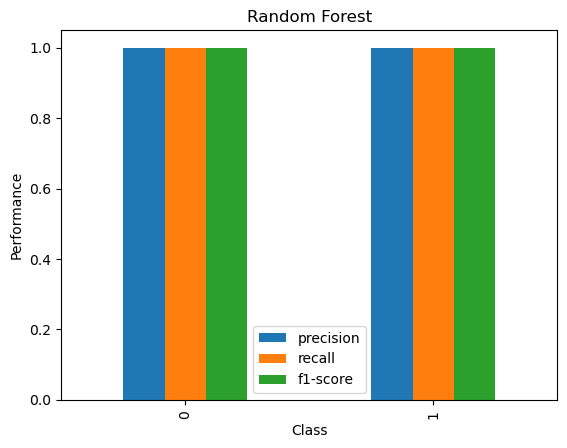

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1824316
           1       1.00      1.00      1.00   1824316

    accuracy                           1.00   3648632
   macro avg       1.00      1.00      1.00   3648632
weighted avg       1.00      1.00      1.00   3648632



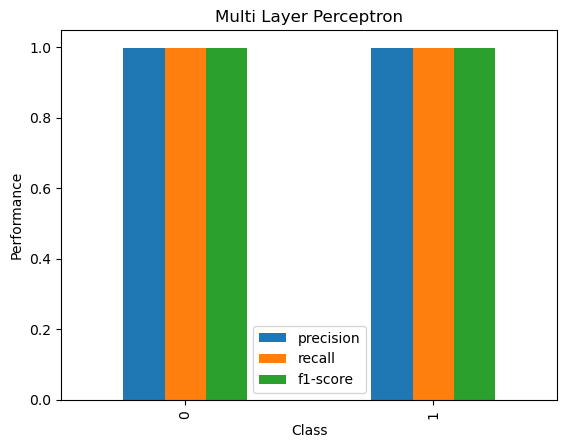

In [143]:
# Perform random over-sampling on dataset

ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X, y)
runModels(X_over, y_over, "Random Oversampling 1:1")

# ros2 = RandomOverSampler(random_state=0, sampling_strategy={1:368549})
# X_over2, y_over2 = ros2.fit_resample(X, y)
# runModels(X_over2, y_over2, "Random Oversampling 10:1")

# ros3 = RandomOverSampler(random_state=0, sampling_strategy={1:36855})
# X_over3, y_over3 = ros3.fit_resample(X, y)
# runModels(X_over3, y_over3, "Random Oversampling 100:1")

### SMOTE - Systematic Minority Oversampling

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

For this experiment, we will oversample the data in ratios 1:1, 10:1 and 100:1 
Since the undersampled data was at ratio 368546:19302 majority class to minority class, smote will scale up the number of datapoints for the minority class to match the above ratios.

Performance metrics for Systematic Majority Oversampling 1:1 data
Counter({0: 5528229, 1: 5528229})
(7407826, 13)
(7407826,)
(3648632, 13)
(3648632,)
              precision    recall  f1-score   support

           0       0.80      0.95      0.87   1824316
           1       0.93      0.76      0.84   1824316

    accuracy                           0.85   3648632
   macro avg       0.87      0.85      0.85   3648632
weighted avg       0.87      0.85      0.85   3648632



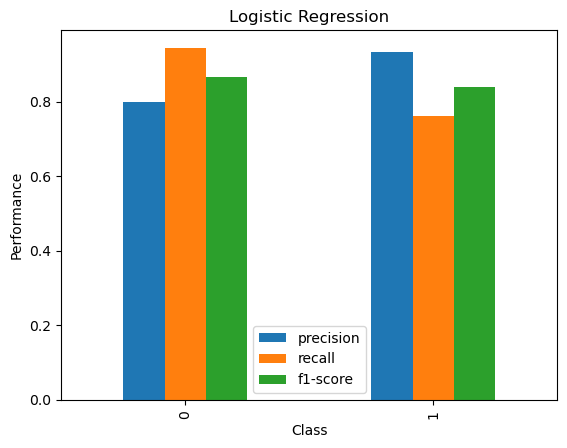

              precision    recall  f1-score   support

           0       0.69      0.99      0.81   1824316
           1       0.98      0.55      0.71   1824316

    accuracy                           0.77   3648632
   macro avg       0.83      0.77      0.76   3648632
weighted avg       0.83      0.77      0.76   3648632



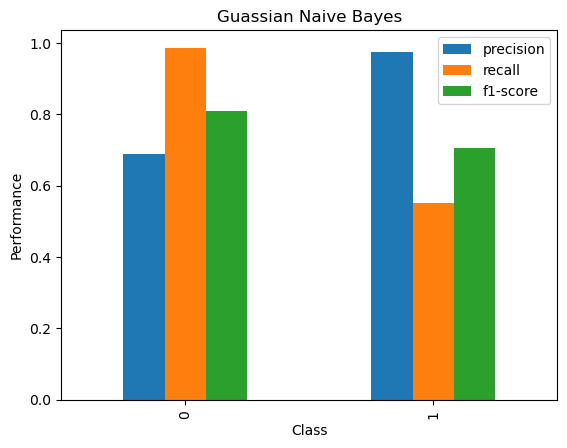

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1824316
           1       1.00      1.00      1.00   1824316

    accuracy                           1.00   3648632
   macro avg       1.00      1.00      1.00   3648632
weighted avg       1.00      1.00      1.00   3648632



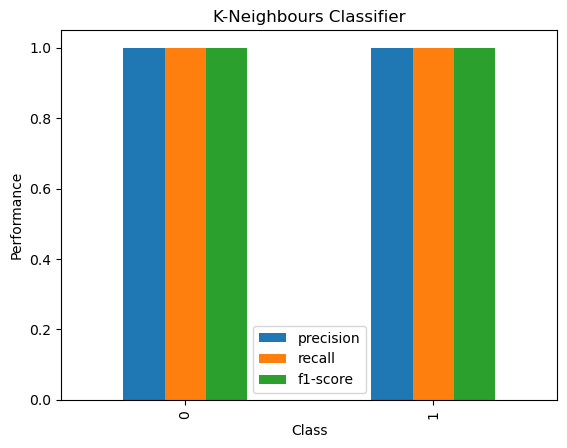

              precision    recall  f1-score   support

           0       0.99      0.98      0.99   1824316
           1       0.98      0.99      0.99   1824316

    accuracy                           0.99   3648632
   macro avg       0.99      0.99      0.99   3648632
weighted avg       0.99      0.99      0.99   3648632



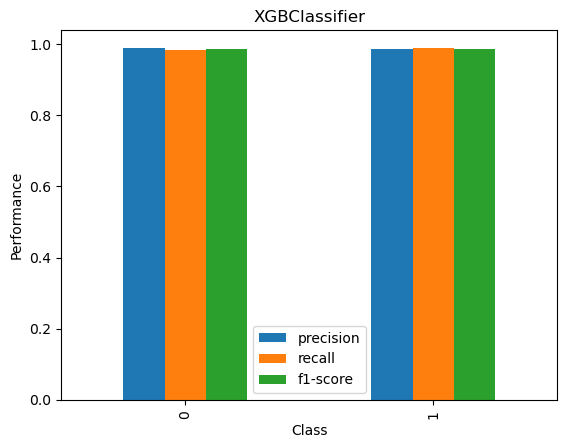

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1824316
           1       1.00      1.00      1.00   1824316

    accuracy                           1.00   3648632
   macro avg       1.00      1.00      1.00   3648632
weighted avg       1.00      1.00      1.00   3648632



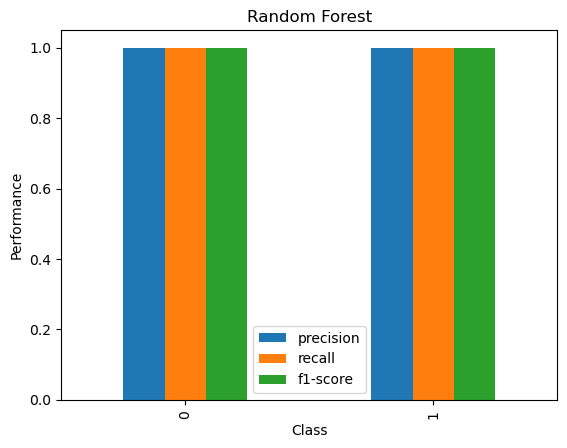

In [ ]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
runModels(X_smote, y_smote, "Systematic Majority Oversampling 1:1")

smote2 = SMOTE(random_state=42, sampling_strategy={1:368549})
X_smote2, y_smote2 = smote2.fit_resample(X, y)
runModels(X_smote2, y_smote2, "Systematic Majority Oversampling 10:1")

smote3 = SMOTE(random_state=42, sampling_strategy={1:36855})
X_smote3, y_smote3  = smote3.fit_resample(X, y)
runModels(X_smote3, y_smote3, "Systematic Majority Oversampling 100:1")

### Random Undersampling

Random undersampling involves randomly selecting examples from the majority class to delete from the training dataset. This has the effect of reducing the number of examples in the majority class in the transformed version of the training dataset.

For this experiment, we will undersample the data in ratios 1:1, 10:1 and 100:1 Since the data was at ratio 368546:19302 majority class to minority class, random undersampling will scale down the number of datapoints for the majority class to match the above ratios.

In [ ]:
# Perform random under-sampling on dataset

rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X, y)
runModels(X_under, y_under, "Random Undersampling 1:1")

# rus2 = RandomUnderSampler(random_state=42, sampling_strategy={0:190000, 1:19000})
# X_under2, y_under2 = rus2.fit_resample(X, y)
# runModels(X_under2, y_under2, "Random Undersampling 10:1")

# rus3 = RandomUnderSampler(random_state=42, sampling_strategy={0:1900000, 1:19000})
# X_under3, y_under3 = rus3.fit_resample(X, y)
# runModels(X_under3, y_under3, "Random Undersampling 100:1")